## 1) Install & Import

In [ ]:
!pip -q install -U transformers accelerate evaluate bert_score rouge-score
!pip -q install "protobuf<5"

import os, random, math, shutil
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
from torch.optim import AdamW
from tqdm import tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56

2025-12-16 20:10:47.069615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765915847.237897      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765915847.284455      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2) Config

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

MODEL_NAME = "cahya/t5-base-indonesian-summarization-cased"

DATASET_DIR = "/kaggle/input/dataset-finetune"
TRAIN_PATH = f"{DATASET_DIR}/data_latih.csv"
VAL_PATH   = f"{DATASET_DIR}/data_validasi.csv"
TEST_PATH  = f"{DATASET_DIR}/data_uji.csv"

TEXT_COL = "content"
SUM_COL  = "summary"

MAX_INPUT_LEN  = 512
MAX_TARGET_LEN = 75
BATCH_SIZE     = 4
LR             = 1e-5
WEIGHT_DECAY   = 0.01
NUM_EPOCHS     = 20
PATIENCE       = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


## 3) Load Data

In [ ]:
def load_csv(path):
    df = pd.read_csv(path)
    df = df[[TEXT_COL, SUM_COL]].dropna()
    df[TEXT_COL] = df[TEXT_COL].astype(str)
    df[SUM_COL]  = df[SUM_COL].astype(str)
    return df.reset_index(drop=True)

df_train = load_csv(TRAIN_PATH)
df_val   = load_csv(VAL_PATH)
df_test  = load_csv(TEST_PATH)

print("Train:", len(df_train), "Val:", len(df_val), "Test:", len(df_test))
df_train.head(2)


Train: 12021 Val: 1503 Test: 1503


,content,summary
0,Direktur Penyidik Jaksa Agung Muda Bidang Tind...,Kejaksaan Agung (Kejagung) menetapkan ibu Rona...
1,Band punk Sukatani mengakui mereka diintimidas...,Band punk Sukatani mengakui bahwa mereka diint...


## 4) Tokenisasi

In [ ]:
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME).to(device)

PREFIX = "ringkasan:"

def tokenize_df(df: pd.DataFrame):
    # input encoding
    inp = tokenizer(
        (PREFIX + df[TEXT_COL]).tolist(),
        max_length=MAX_INPUT_LEN,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    # target encoding
    tgt = tokenizer(
        df[SUM_COL].tolist(),
        max_length=MAX_TARGET_LEN,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    out = df.copy()
    out["input_ids"] = inp["input_ids"].tolist()
    out["attention_mask"] = inp["attention_mask"].tolist()
    out["labels"] = tgt["input_ids"].tolist()
    return out[[TEXT_COL, SUM_COL, "input_ids", "attention_mask", "labels"]]

train_data = tokenize_df(df_train)
val_data   = tokenize_df(df_val)
test_data  = tokenize_df(df_test)

train_data.head(2)


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/793k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/657 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

,content,summary,input_ids,attention_mask,labels
0,Direktur Penyidik Jaksa Agung Muda Bidang Tind...,Kejaksaan Agung (Kejagung) menetapkan ibu Rona...,"[7279, 1283, 6519, 2756, 26199, 1579, 1540, 59...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[30707, 1579, 15, 4, 1756, 1433, 8013, 5, 1929..."
1,Band punk Sukatani mengakui mereka diintimidas...,Band punk Sukatani mengakui bahwa mereka diint...,"[6075, 393, 139, 3663, 7283, 2117, 45, 18, 52,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[6075, 393, 139, 3663, 7283, 2117, 883, 45, 18..."


## 5) Dataset + DataLoader

In [ ]:
class SummaryDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.data.loc[idx, "input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(self.data.loc[idx, "attention_mask"], dtype=torch.long),
            "labels": torch.tensor(self.data.loc[idx, "labels"], dtype=torch.long),
        }

train_loader = DataLoader(SummaryDataset(train_data), batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(SummaryDataset(val_data), batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(SummaryDataset(test_data), batch_size=BATCH_SIZE, shuffle=False)


## 6) Checkpoint

In [ ]:
checkpoint_dir = "/kaggle/working/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

last_ckpt_path = os.path.join(checkpoint_dir, "checkpoint_last.pt")
best_ckpt_path = os.path.join(checkpoint_dir, "checkpoint_best.pt")

def save_checkpoint(path, epoch, model, optimizer, train_losses, val_losses, best_val_loss):
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_losses": train_losses,
        "val_losses": val_losses,
        "best_val_loss": best_val_loss
    }, path)
    print(f"[Checkpoint saved] {path}")

def load_checkpoint(path, model, optimizer, device):
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])
    optimizer.load_state_dict(ckpt["optimizer_state_dict"])
    start_epoch = ckpt["epoch"]
    train_losses = ckpt.get("train_losses", [])
    val_losses   = ckpt.get("val_losses", [])
    best_val_loss = ckpt.get("best_val_loss", float("inf"))
    print(f"[Resumed] from epoch {start_epoch}")
    return start_epoch, train_losses, val_losses, best_val_loss


### Cek Checkpoint

In [ ]:
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

import shutil
import os

# === sumber checkpoint dari Kaggle Input ===
INPUT_CKPT_DIR = "/kaggle/input/my-checkpoints/checkpoints"
# ⬆️ ganti 'my-checkpoints' sesuai nama dataset kamu


checkpoint_dir = "/kaggle/working/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)


if os.path.exists(INPUT_CKPT_DIR):
    shutil.copytree(INPUT_CKPT_DIR, checkpoint_dir, dirs_exist_ok=True)
    print("✅ Checkpoints copied from input to working.")
else:
    print("⚠️ No checkpoint found in input. Fresh training.")

# path file
last_ckpt_path = os.path.join(checkpoint_dir, "checkpoint_last.pt")
best_ckpt_path = os.path.join(checkpoint_dir, "checkpoint_best.pt")

# init default
start_epoch, train_losses, val_losses, best_val_loss = 0, [], [], float("inf")

# load checkpoint untuk resume training
if os.path.exists(last_ckpt_path):
    start_epoch, train_losses, val_losses, best_val_loss = load_checkpoint(
        last_ckpt_path, model, optimizer, device
    )
else:
    print("[Info] Starting from epoch 0.")

epochs_no_improve = 0


⚠️ No checkpoint found in input. Fresh training.
[Info] Starting from epoch 0.


# 7) Training Loop

In [ ]:

for epoch in range(start_epoch, NUM_EPOCHS):
    # ---- Train ----
    model.train()
    total_train_loss = 0.0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ---- Val ----
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            input_ids      = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels         = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            total_val_loss += outputs.loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1} => Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # save last
    save_checkpoint(last_ckpt_path, epoch+1, model, optimizer, train_losses, val_losses, best_val_loss)

    # save best + early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        save_checkpoint(best_ckpt_path, epoch+1, model, optimizer, train_losses, val_losses, best_val_loss)
        print(f">> New best model saved (Val Loss: {best_val_loss:.4f})")
    else:
        epochs_no_improve += 1
        print(f">> No improvement for {epochs_no_improve} epoch(s). Best Val Loss: {best_val_loss:.4f}")

        if epochs_no_improve >= PATIENCE:
            print(f"[EARLY STOPPING] No improvement for {PATIENCE} consecutive epochs.")
            break


Epoch 1 [Val]: 100%|██████████| 376/376 [01:36<00:00,  3.91it/s]


Epoch 1 => Train Loss: 0.4907 | Val Loss: 0.2877
[Checkpoint saved] /kaggle/working/checkpoints/checkpoint_last.pt
[Checkpoint saved] /kaggle/working/checkpoints/checkpoint_best.pt
>> New best model saved (Val Loss: 0.2877)


Epoch 2 [Val]: 100%|██████████| 376/376 [01:36<00:00,  3.90it/s]


Epoch 2 => Train Loss: 0.2918 | Val Loss: 0.2774
[Checkpoint saved] /kaggle/working/checkpoints/checkpoint_last.pt
[Checkpoint saved] /kaggle/working/checkpoints/checkpoint_best.pt
>> New best model saved (Val Loss: 0.2774)


Epoch 3 [Val]: 100%|██████████| 376/376 [01:35<00:00,  3.93it/s]


Epoch 3 => Train Loss: 0.2752 | Val Loss: 0.2715
[Checkpoint saved] /kaggle/working/checkpoints/checkpoint_last.pt
[Checkpoint saved] /kaggle/working/checkpoints/checkpoint_best.pt
>> New best model saved (Val Loss: 0.2715)


Epoch 4 [Val]: 100%|██████████| 376/376 [01:36<00:00,  3.91it/s]


Epoch 4 => Train Loss: 0.2621 | Val Loss: 0.2691
[Checkpoint saved] /kaggle/working/checkpoints/checkpoint_last.pt
[Checkpoint saved] /kaggle/working/checkpoints/checkpoint_best.pt
>> New best model saved (Val Loss: 0.2691)


Epoch 5 [Val]: 100%|██████████| 376/376 [01:36<00:00,  3.90it/s]


Epoch 5 => Train Loss: 0.2509 | Val Loss: 0.2676
[Checkpoint saved] /kaggle/working/checkpoints/checkpoint_last.pt
[Checkpoint saved] /kaggle/working/checkpoints/checkpoint_best.pt
>> New best model saved (Val Loss: 0.2676)


Epoch 6 [Val]: 100%|██████████| 376/376 [01:35<00:00,  3.92it/s]


Epoch 6 => Train Loss: 0.2407 | Val Loss: 0.2686
[Checkpoint saved] /kaggle/working/checkpoints/checkpoint_last.pt
>> No improvement for 1 epoch(s). Best Val Loss: 0.2676


Epoch 7 [Val]: 100%|██████████| 376/376 [01:36<00:00,  3.91it/s]


Epoch 7 => Train Loss: 0.2315 | Val Loss: 0.2674
[Checkpoint saved] /kaggle/working/checkpoints/checkpoint_last.pt
[Checkpoint saved] /kaggle/working/checkpoints/checkpoint_best.pt
>> New best model saved (Val Loss: 0.2674)


Epoch 8 [Val]: 100%|██████████| 376/376 [01:36<00:00,  3.90it/s]


Epoch 8 => Train Loss: 0.2228 | Val Loss: 0.2691
[Checkpoint saved] /kaggle/working/checkpoints/checkpoint_last.pt
>> No improvement for 1 epoch(s). Best Val Loss: 0.2674


Epoch 9 [Val]: 100%|██████████| 376/376 [01:36<00:00,  3.90it/s]


Epoch 9 => Train Loss: 0.2144 | Val Loss: 0.2699
[Checkpoint saved] /kaggle/working/checkpoints/checkpoint_last.pt
>> No improvement for 2 epoch(s). Best Val Loss: 0.2674


Epoch 10 [Val]: 100%|██████████| 376/376 [01:36<00:00,  3.91it/s]


Epoch 10 => Train Loss: 0.2070 | Val Loss: 0.2710
[Checkpoint saved] /kaggle/working/checkpoints/checkpoint_last.pt
>> No improvement for 3 epoch(s). Best Val Loss: 0.2674
[EARLY STOPPING] No improvement for 3 consecutive epochs.


# 8) Visualisasi Learning Curve

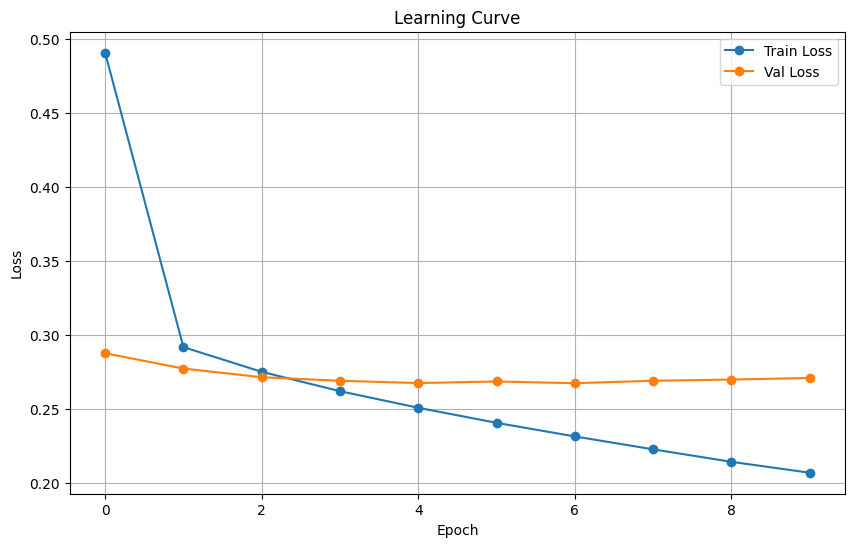

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Val Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.grid(True)
plt.legend()
plt.show()


# 9) Load Best Model

In [ ]:
# load best checkpoint
ckpt = torch.load(best_ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
model.eval()
print("Loaded best checkpoint from epoch:", ckpt["epoch"])


Loaded best checkpoint from epoch: 7


# 10) Inference

In [ ]:
def generate_abstractive(text: str):
    inputs = tokenizer(
        PREFIX + text,
        return_tensors="pt",
        max_length=MAX_INPUT_LEN,
        truncation=True
    ).to(device)

    # decoding "abstraktif"
    out = model.generate(
        **inputs,
        max_new_tokens=MAX_INPUT_LENGTH,
        no_repeat_ngram_size=3,
        repetition_penalty=1.15
    )
    return tokenizer.decode(out[0], skip_special_tokens=True).strip()


# 11) Uji Kualiatatif (Test Uji)

In [ ]:
for i in range(min(15, len(df_test))):
    content = df_test.iloc[i][TEXT_COL]
    reference = df_test.iloc[i][SUM_COL]
    predicted = generate_abstractive(content)

    print(f"\n📄 Artikel Uji {i+1}")
    print("Content:", content[:260].replace("\n", " ").strip(), "...")
    print("Reference:", reference.strip())
    print("Predicted:", predicted)



📄 Artikel Uji 1
Content: Seorang pengunjung Kebun Raya Bogor mengeluhkan adanya dugaan pungutan liar (pungli) yang dilakukan oleh pengelola terhadapnya dan puluhan rekannya saat gathering menggelar sejumlah perlombaan di lapangan Cappelen, Kebun Raya Bogor. Dugaan pungutan liar (pungl ...
Reference: Sekuriti Kebun Raya Bogor menanyakan kepada panitia lantaran mereka tak memberi tahu ke pengelola ihwal acara bersama rombongan.
Predicted: Pengunggah video mengatakan lantaran acaranya diikuti 50 orang lebih dan menggunakan pengeras suara, ia diminta membayar Rp 15 ribu per orang.

📄 Artikel Uji 2
Content: Lembaga Bantuan Hukum (LBH) Padang mengirim somasi kepada Polda Sumatera Barat pada Rabu, 5 Februari 2025 karena tidak memenuhi putusan Komisi Informasi (KI) Nomor 22/VIII/KISB-PS-M-A/2024. Putusan itu memerintahkan Polda Sumbar dalam 14 hari kerja agar member ...
Reference: Komisi Informasi mengabulkan permohonan LBH Padang agar Polda Sumatera Barat menyerahkan hasil autopsi almarhum A

# 12) Uji Seberapa Ekstraktif

In [ ]:
def ngram_set(text, n=4):
    tokens = text.lower().split()
    return set(tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1))

def extractiveness_score(input_text, summary_text, n=4):
    inp = ngram_set(input_text, n)
    summ = ngram_set(summary_text, n)
    if len(summ) == 0:
        return 0.0
    return len(inp.intersection(summ)) / len(summ)

scores = []
for i in range(min(200, len(df_test))):
    inp = df_test.iloc[i][TEXT_COL]
    pred = generate_abstractive(inp)
    scores.append(extractiveness_score(inp, pred, n=4))

print("Avg 4-gram overlap (lebih kecil = lebih abstraktif):", float(np.mean(scores)))


Avg 4-gram overlap (lebih kecil = lebih abstraktif): 0.5111799264399396


# 13) Save Model

In [ ]:
save_path = "/kaggle/working/finetuned_t5_cahya_abstractive"
os.makedirs(save_path, exist_ok=True)

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print("Saved model to:", save_path)

# zip model folder
shutil.make_archive(save_path, "zip", save_path)
print("Zipped:", save_path + ".zip")

# zip checkpoints folder
shutil.make_archive(checkpoint_dir, "zip", checkpoint_dir)
print("Zipped:", checkpoint_dir + ".zip")


Saved model to: /kaggle/working/finetuned_t5_cahya_abstractive
Zipped: /kaggle/working/finetuned_t5_cahya_abstractive.zip
Zipped: /kaggle/working/checkpoints.zip


# 14) Metrik Evaluasi

In [ ]:
import evaluate
import numpy as np
from tqdm import tqdm

rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")
bertscore = evaluate.load("bertscore")


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [ ]:
predictions = []
references = []

model.eval()

for i in tqdm(range(len(df_test)), desc="Generating abstractive summaries"):
    content = df_test.iloc[i][TEXT_COL]
    reference = df_test.iloc[i][SUM_COL]

    pred = generate_abstractive(content)

    predictions.append(pred)
    references.append(reference)


Generating abstractive summaries: 100%|██████████| 1503/1503 [13:11<00:00,  1.90it/s]


In [ ]:
rouge_result = rouge.compute(
    predictions=predictions,
    references=references
)

meteor_result = meteor.compute(
    predictions=predictions,
    references=references
)

bertscore_result = bertscore.compute(
    predictions=predictions,
    references=references,
    lang="id"
)


print("\n🔹 METEOR")
print(f"METEOR     : {meteor_result['meteor']:.4f}")

print("\n🔹 ROUGE")
print(f"ROUGE-1    : {rouge_result['rouge1']:.4f}")
print(f"ROUGE-2    : {rouge_result['rouge2']:.4f}")
print(f"ROUGE-L    : {rouge_result['rougeL']:.4f}")
print(f"ROUGE-Lsum : {rouge_result['rougeLsum']:.4f}")


print("\n🔹 BERTScore")
print(f"Precision  : {np.mean(bertscore_result['precision']):.4f}")
print(f"Recall     : {np.mean(bertscore_result['recall']):.4f}")
print(f"F1         : {np.mean(bertscore_result['f1']):.4f}")


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]


🔹 METEOR
METEOR     : 0.3072

🔹 ROUGE
ROUGE-1    : 0.3179
ROUGE-2    : 0.1668
ROUGE-L    : 0.2807
ROUGE-Lsum : 0.2805

🔹 BERTScore
Precision  : 0.7495
Recall     : 0.7618
F1         : 0.7553
